In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import glob
from astropy import units as u
from astropy import constants as const
import time
from astropy.stats import SigmaClip
from dust_extinction.parameter_averages import F99
from spec_modelfit import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Load data spectrum and define grid of _empirical spectra_ to compare against:

In [2]:
# shamelessly stolen out of the astropy specutils library, and not useful here because we're only working in air (!): 
# https://github.com/astropy/specutils/blob/0933a8e271ab1e333337087433cb683da8ab5a54/specutils/utils/wcs_utils.py#L366    
def vac_to_air(wavelength):
    """
    Griesen 2006 reports that the error in naively inverting Eqn 65 is less
    than 10^-9 and therefore acceptable.  This is therefore eqn 67
    """
    wlum = wavelength.to(u.um).value
    nl = (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4))
    return wavelength/nl    

def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength

In [23]:
# newest xshooter spectrum instead
# data = np.loadtxt('../RV/xshooter_oct_medvis.txt', skiprows=1) # optical Oct data
data = np.loadtxt('../RV/xshooter_dec_medvis.txt', skiprows=1) # optical Dec data
# data = np.loadtxt('../RV/xshooter_mednir_dec.txt', skiprows=1) # NIR Dec data


wavelength_object = np.nan_to_num(data[:, 0])
flux_object = np.nan_to_num(data[:, 1])
uncertainty_object = np.nan_to_num(data[:, 2])

# clean up the values where the uncertainty is zero:
wavelength_object = wavelength_object[uncertainty_object != 0]
flux_object = flux_object[uncertainty_object != 0]
uncertainty_object = uncertainty_object[uncertainty_object != 0]

In [24]:
# Do conversion from air (X-shooter) to vacuum (BT Settl) - not necessary for X-shooter library
# wv_obj_vac = air_to_vac(wavelength_object*u.nanometer)
# wavelength_object = wv_obj_vac.value

In [25]:
# set type of data!
optical = True
NIR = False
UV = False

trim = False

In [26]:
# optional: trim the noisy parts - OPTICAL:
if optical==True:
    wavelength_object /= 1000 # to microns
    
    if trim == True:
        flux_object = flux_object[wavelength_object > .670]
        uncertainty_object = uncertainty_object[wavelength_object > .670]
        wavelength_object = wavelength_object[wavelength_object > .670]

In [27]:
# trim the noisy parts - NIR:
if NIR == True:
    flux_object = flux_object[wavelength_object < 2500]
    uncertainty_object = uncertainty_object[wavelength_object < 2500]
    uncertainty_object[np.where(uncertainty_object==0)] = np.median(uncertainty_object)
    wavelength_object = wavelength_object[wavelength_object < 2500]/1000 # to microns    

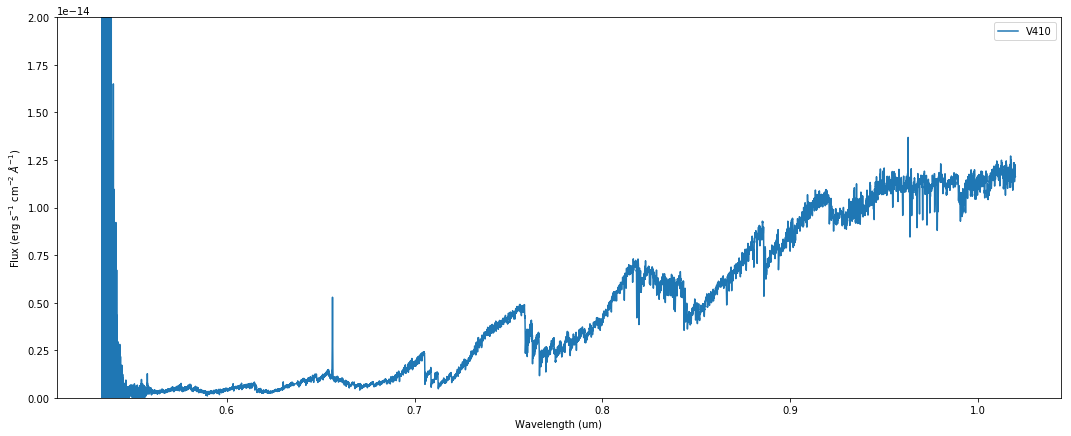

In [28]:
# plot reduced spectrum:
fig = plt.figure(figsize=(18,7))
plt.plot(wavelength_object, flux_object, label='V410')
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.legend()
plt.ylim(0,2e-14)
plt.show()

## Load in an example spectrum from Manara et al. 2013b - these are the ESO reductions:

In [29]:
"""SZ107"""
# m13_data = fits.getdata('Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_25.843.fits') # nir
# m13_data = fits.getdata('Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_25.457.fits') # uv
filename = "Extinction/Manara2013_Library/XShooterPhaseIIIReductions/Sz107/ADP.2014-05-16T21_35_26.530.fits"
m13_data = fits.getdata(filename)


"""SO925"""
# m13_data = fits.getdata('Extinction/Manara2013_Library/SO925/ADP.2014-05-13T15_37_26.653.fits') # opt 

wavelength_m13 = m13_data[0][0]/1000 # to microns
flux_m13 = m13_data[0][1]
uncertainty_m13 = m13_data[0][2]

if trim == True:
    flux_m13 = flux_m13[wavelength_m13 > .670]
    uncertainty_m13 = uncertainty_m13[wavelength_m13 > .670]
    wavelength_m13 = wavelength_m13[wavelength_m13 > .670]

NameError: name 'wv' is not defined

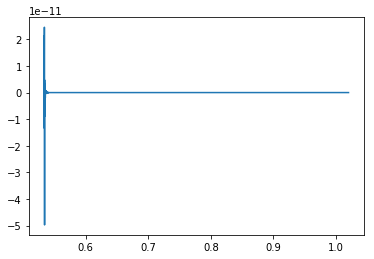

In [30]:
plt.plot(wavelength_m13, flux_m13, label='ESO Reduction')
plt.plot(wv/1000, testfl.value, label='VizieR')
plt.legend(loc=2)
plt.ylim(0,0.1e-13)

## Load in Manara+ spectra, but from their own reductions (VizieR):

In [32]:
ls Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_V.txt

ESOPhaseIII_Reader.ipynb          Veiling.ipynb
EmpiricalAvFitter-Xshooter.ipynb  __pycache__/
EqW.py                            coarse_grid_BTSettl_results.txt
Extinction/                       eso_1dspectrum.py
README.md                         eso_1dspectrum.pyc
SyntheticAvFitter-SpeX.ipynb      spec_modelfit.py
SyntheticAvFitter-Xshooter.ipynb  spec_modelfit.pyc
V410_SpeX_experiments.ipynb


In [33]:
# Note that the units are in nm, and mW/m**2/nm.
wv, fl = np.genfromtxt('Extinction/Manara2013_Library/ManaraReductions/08_Sz107_M5.5_V.txt', skip_header=1, unpack=True)

In [34]:
testfl = fl*(u.mW)*(u.m**-2)*(u.nm**-1)

In [35]:
testfl2 = testfl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1))

In [36]:
testfl2

<Quantity [0.00000e+00, 5.98991e-16, 7.33483e-17, ..., 8.39918e-15,
           8.57421e-15, 0.00000e+00] erg / (Angstrom cm2 s)>

In [37]:
# read all of the visible arm spectra into a dictionary:
manara_spec = {}
V_templates = glob.glob('Extinction/Manara2013_Library/ManaraReductions/*_V.txt')

In [38]:
for templ in V_templates:
    wv, fl = np.genfromtxt(templ, skip_header=1, unpack=True)
    fl = fl*(u.mW)*(u.m**-2)*(u.nm**-1)
    conv_fl = fl.to((u.erg)*(u.s**-1)*(u.cm**-2)*(u.angstrom**-1))
    manara_spec[templ] = (wv, conv_fl.value)

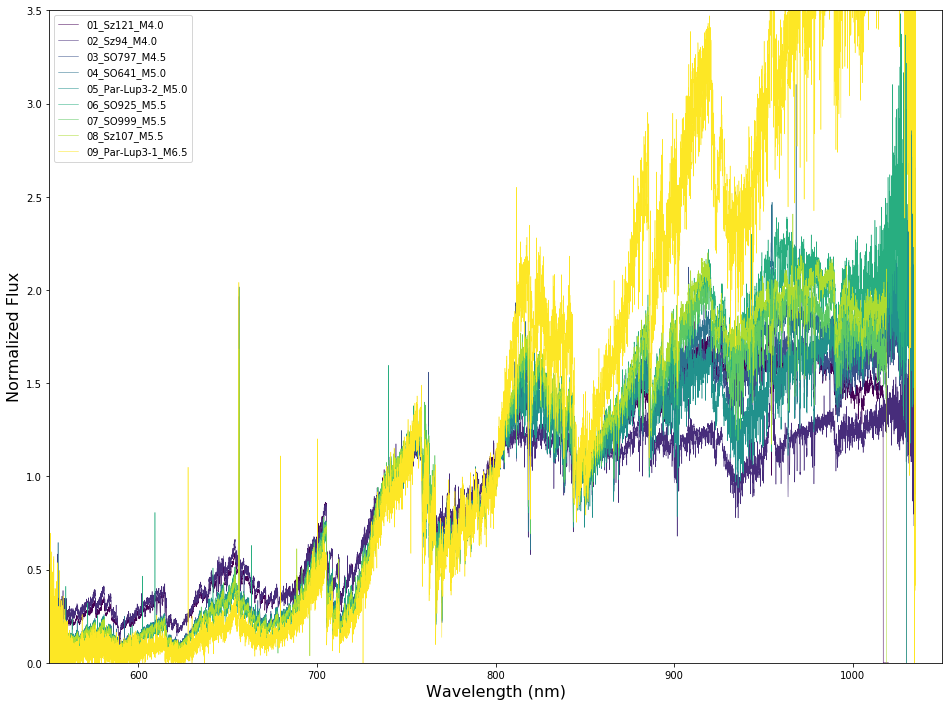

In [70]:
plt.figure(figsize=(16,12))

colors = plt.cm.viridis(np.linspace(0,1,len(V_templates)))

for idx,templ in enumerate(V_templates):
    plt.plot(manara_spec[templ][0], manara_spec[templ][1]/np.median(manara_spec[templ][1]), \
             lw=0.5, color=colors[idx],
             label=templ.split('/')[-1].strip('_V.txt'))
plt.xlabel('Wavelength (nm)', size=16)
# plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=16)
plt.ylabel('Normalized Flux', size=16)
# plt.ylim(0,3e-14)
plt.ylim(0,3.5)
plt.xlim(550,1050)
plt.legend(loc=2)

## An experiment to try spectral typing one of the known members against each other 

First, let's look at the objects most like the suspected V410 type (M5.5):

In [54]:
wavelength_object

array([0.53366523, 0.53368523, 0.53370523, ..., 1.01993178, 1.01995178,
       1.01997178])

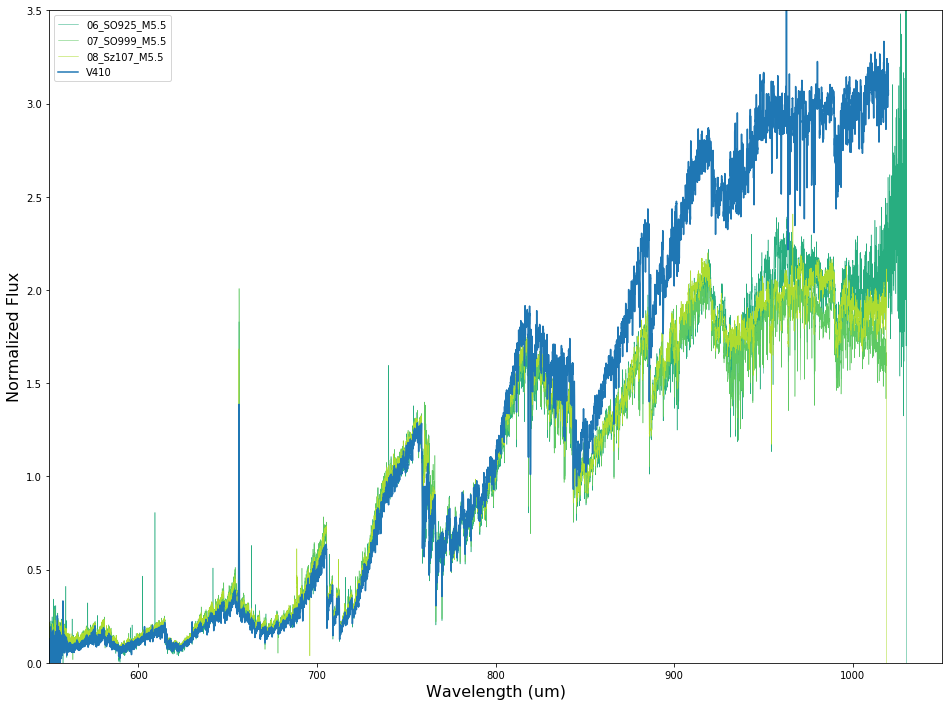

In [57]:
plt.figure(figsize=(16,12))

colors = plt.cm.viridis(np.linspace(0,1,len(V_templates)))

for idx,templ in enumerate(V_templates):
    if 'M5.5' in templ:
        plt.plot(manara_spec[templ][0], manara_spec[templ][1]/np.median(manara_spec[templ][1]), \
             lw=0.5, color=colors[idx],
             label=templ.split('/')[-1].strip('_V.txt'))
        
plt.plot(wavelength_object*1000, flux_object/np.median(flux_object), label='V410')        
plt.xlabel('Wavelength (um)', size=16)
# plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=16)
plt.ylabel('Normalized Flux', size=16)
# plt.ylim(0,3e-14)
plt.ylim(0,3.5)
plt.xlim(550,1050)
plt.legend(loc=2)

But actually, the increased flux near the NIR suggests it's a later spectral type...

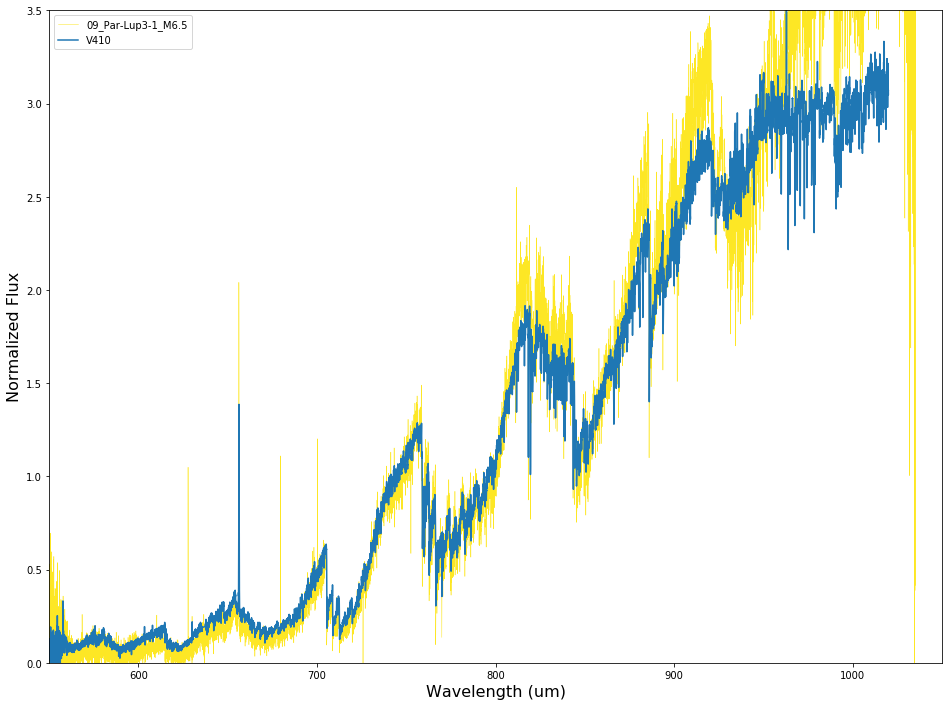

In [58]:
plt.figure(figsize=(16,12))

colors = plt.cm.viridis(np.linspace(0,1,len(V_templates)))

for idx,templ in enumerate(V_templates):
    if 'M6' in templ:
        plt.plot(manara_spec[templ][0], manara_spec[templ][1]/np.median(manara_spec[templ][1]), \
             lw=0.5, color=colors[idx],
             label=templ.split('/')[-1].strip('_V.txt'))
        
plt.plot(wavelength_object*1000, flux_object/np.median(flux_object), label='V410')        
plt.xlabel('Wavelength (um)', size=16)
# plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=16)
plt.ylabel('Normalized Flux', size=16)
# plt.ylim(0,3e-14)
plt.ylim(0,3.5)
plt.xlim(550,1050)
plt.legend(loc=2)

Now it's a little too bright at short wavelengths, and a little too dim in the NIR. We don't have a M6.0 in the library, so what if we averaged an M5.5 and M6 template?

In [59]:
manara_spec

{'Extinction/Manara2013_Library/ManaraReductions/01_Sz121_M4.0_V.txt': (array([ 533.66,  533.68,  533.7 , ..., 1019.94, 1019.96, 1019.98]),
  array([0., 0., 0., ..., 0., 0., 0.])),
 'Extinction/Manara2013_Library/ManaraReductions/02_Sz94_M4.0_V.txt': (array([ 545.  ,  545.02,  545.04, ..., 1034.96, 1034.98, 1035.  ]),
  array([0.00000e+00, 3.23075e-15, 1.55470e-15, ..., 1.06379e-14,
         1.20707e-14, 6.87806e-15])),
 'Extinction/Manara2013_Library/ManaraReductions/03_SO797_M4.5_V.txt': (array([ 545.99,  546.02,  546.05, ..., 1029.96, 1029.99, 1030.01]),
  array([0.00000e+00, 9.37423e-17, 5.61343e-17, ..., 9.05031e-16,
         0.00000e+00, 0.00000e+00])),
 'Extinction/Manara2013_Library/ManaraReductions/04_SO641_M5.0_V.txt': (array([ 546.  ,  546.03,  546.06, ..., 1029.94, 1029.97, 1030.  ]),
  array([ 0.00000e+00,  5.82717e-17, -6.35181e-18, ...,  6.10954e-16,
          6.46228e-16,  0.00000e+00])),
 'Extinction/Manara2013_Library/ManaraReductions/05_Par-Lup3-2_M5.0_V.txt': (array

In [69]:
m55 = 'Extinction/Manara2013_Library/ManaraReductions/06_SO925_M5.5_V.txt'
m65 = 'Extinction/Manara2013_Library/ManaraReductions/09_Par-Lup3-1_M6.5_V.txt'

m6_averaged = ((manara_spec[m55][1]/np.median(manara_spec[m55][1]))+ \
            (manara_spec[m65][1]/np.median(manara_spec[m65][1])))/2.0

ValueError: operands could not be broadcast together with shapes (16865,) (24501,) 

In [68]:
len(manara_spec[m55][1])

16482

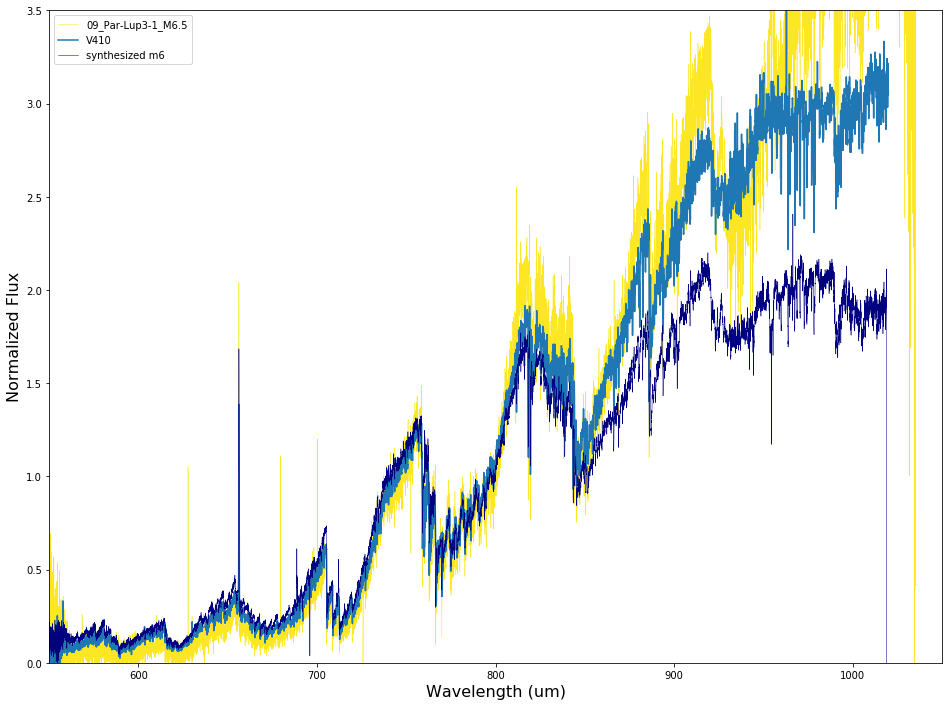

In [63]:
plt.figure(figsize=(16,12))

colors = plt.cm.viridis(np.linspace(0,1,len(V_templates)))

for idx,templ in enumerate(V_templates):
    if 'M6' in templ:
        plt.plot(manara_spec[templ][0], manara_spec[templ][1]/np.median(manara_spec[templ][1]), \
             lw=0.5, color=colors[idx],
             label=templ.split('/')[-1].strip('_V.txt'))
        
plt.plot(wavelength_object*1000, flux_object/np.median(flux_object), label='V410')  

plt.plot(manara_spec[m55][0], m6_averaged, lw=0.5, color = 'navy', label='synthesized m6')

plt.xlabel('Wavelength (um)', size=16)
# plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=16)
plt.ylabel('Normalized Flux', size=16)
# plt.ylim(0,3e-14)
plt.ylim(0,3.5)
plt.xlim(550,1050)
plt.legend(loc=2)

ValueError: x and y must have same first dimension, but have shapes (24501,) and (23651,)

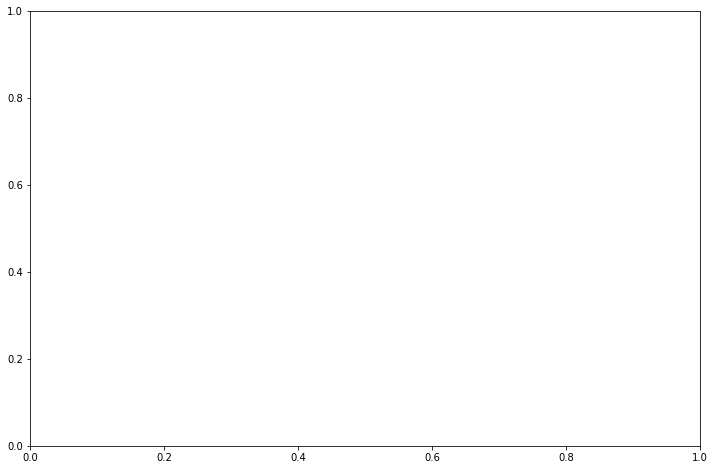

In [40]:
plt.figure(figsize=(12,8))
plt.plot(wv, testfl2.value, c='r', label='Sz107, Manara Published Reduction')
plt.plot(wavelength_m13*1000, flux_m13, c='b', label='Sz107, ESO Pipeline Reduction')
plt.plot(wavelength_object*1000, flux_object, c='g', label='V410') 
plt.xlabel('Wavelength (um)', size=16)
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=16)
plt.ylim(0,1.5e-14)
plt.xlim(600,1050)
plt.legend(loc=2)

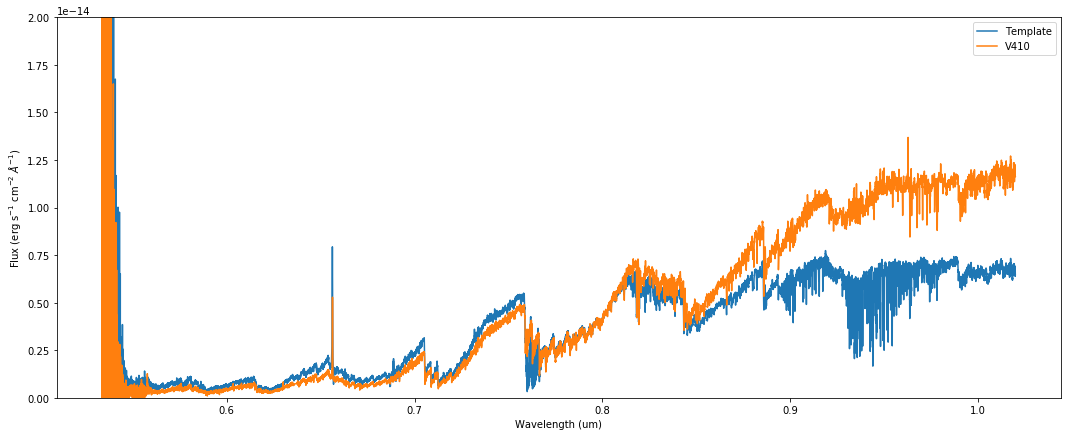

In [41]:
# plot template spectrum:
fig = plt.figure(figsize=(18,7))
# plt.plot(wavelength_m13, flux_m13/np.median(flux_m13[(wavelength_m13 > 1.5) & (wavelength_m13 < 1.7)]), label='Sz107') #normalize to peak of H-band
plt.plot(wavelength_m13, flux_m13, label='Template') 


plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')

# plt.plot(wavelength_object, flux_object/np.median(flux_object[(wavelength_object > 1.5) & (wavelength_object < 1.7)]), label='V410') #normalize to peak of H-band
plt.plot(wavelength_object, flux_object, label='V410') 

plt.legend()
plt.ylim(0,2e-14)
# plt.xlim(2.46, 2.5)
plt.show()

## Now try scaling for distance:

In [42]:
# V410 distance:
d_v410 = 1000/8.3771

# sz107 distance
d_sz107 = 1000/6.5635
scale_factor = (d_sz107/d_v410)**2
scale_factor

1.6289825061877268

ValueError: x and y must have same first dimension, but have shapes (24501,) and (23651,)

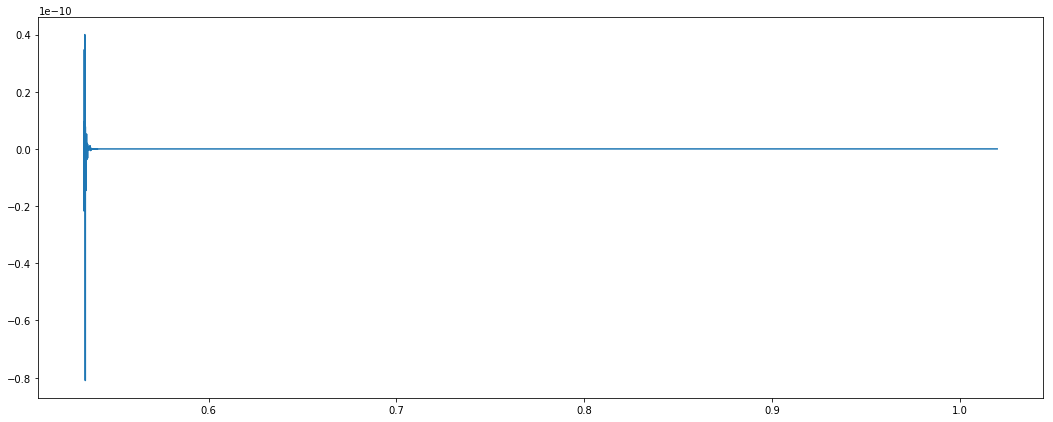

In [43]:
# plot template spectrum:
fig = plt.figure(figsize=(18,7))
# plt.plot(wavelength_m13, flux_m13/np.median(flux_m13[(wavelength_m13 > 1.5) & (wavelength_m13 < 1.7)]), label='Sz107') #normalize to peak of H-band
plt.plot(wavelength_m13, flux_m13*scale_factor, label='Sz107 ESO Reduc., scaled to V410 dist') 
plt.plot(wv/1000, testfl2.value*scale_factor, c='r', label='Sz107 Manara Reduc., scaled to V410 dist')



plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')

# plt.plot(wavelength_object, flux_object/np.median(flux_object[(wavelength_object > 1.5) & (wavelength_object < 1.7)]), label='V410') #normalize to peak of H-band
plt.plot(wavelength_object, flux_object, label='V410') 

plt.legend()
plt.ylim(0,2e-14)
# plt.xlim(2.46, 2.5)
plt.show()

## Now check to see how extinction impacts the fits:

In [218]:
# rebin each template to match the same wavelength axis - should be nearly identical:
templ_rebinflux = rebinspec(wavelength_m13, flux_m13*scale_factor, wavelength_object)

temp_manara_rebinflux = rebinspec(wv/1000, testfl2.value*scale_factor, wavelength_object)

# now we can do everything with the x-axis w.r.t. wavelength_object

spec_modelfit.py:168: RuntimeWarning: invalid value encountered in divide
  fxOut = nwfx/nwunitfx


In [272]:
# try adding some extinction - is that what's occurring here? 
ext = F99(Rv=6) # 3.1
av = 1.15
spectrum_ext = templ_rebinflux*ext.extinguish(wavelength_object*u.um, Av=av)
spectrum_ext_manara = temp_manara_rebinflux*ext.extinguish(wavelength_object*u.um, Av=av)

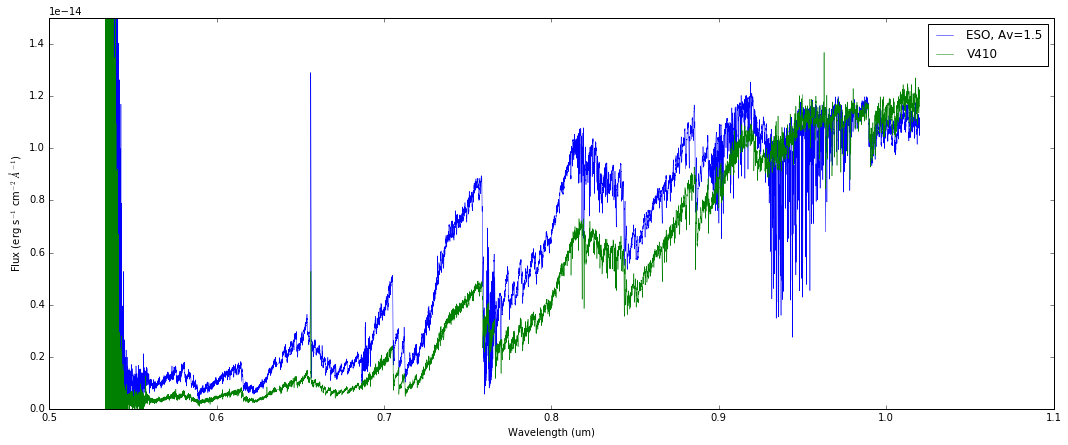

In [274]:
# plot template spectrum:
fig = plt.figure(figsize=(18,7))

# plt.plot(wavelength_object, spectrum_ext/np.median(spectrum_ext), lw=0.5, label='Sz107') #normalize to peak of H-band
# plt.plot(wavelength_object, spectrum_ext*45, lw=0.5, label='Template') #not normalized
# plt.plot(wavelength_object, flux_object/np.median(flux_object)+0.4, lw=0.5, label='V410') #normalize to peak of H-band

plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')

# plt.plot(wavelength_object, spectrum_ext_manara, lw=0.5, c='r', label='Manara, Av=1.5') #not normalized
plt.plot(wavelength_object, templ_rebinflux, lw=0.5, c='b',label='ESO, Av=1.5') #not normalized
plt.plot(wavelength_object, flux_object, lw=0.5, c='g', label='V410') #not normalized
plt.legend()
plt.ylim(0,1.5e-14)

# plt.ylim(0,0.3e-14)
# plt.xlim(0.6, 0.7)
# plt.xlim(0.65, 0.69)
plt.show()

In [18]:
def sigclip_spec(flux):
    sigclip = SigmaClip(sigma=3)#, maxiters=10) # note version of astropy appears to depend on whether maxiters works
    newflux = np.copy(flux)
    filtered_data = sigclip(newflux, copy=True)
    for idx, entry in enumerate(np.where(filtered_data.mask==True)[0]):
        newflux[entry] = np.median(newflux[(entry-25):(entry+25)])
    return newflux

In [19]:
newspec = sigclip_spec(spectrum_ext)
newobj = sigclip_spec(flux_object)

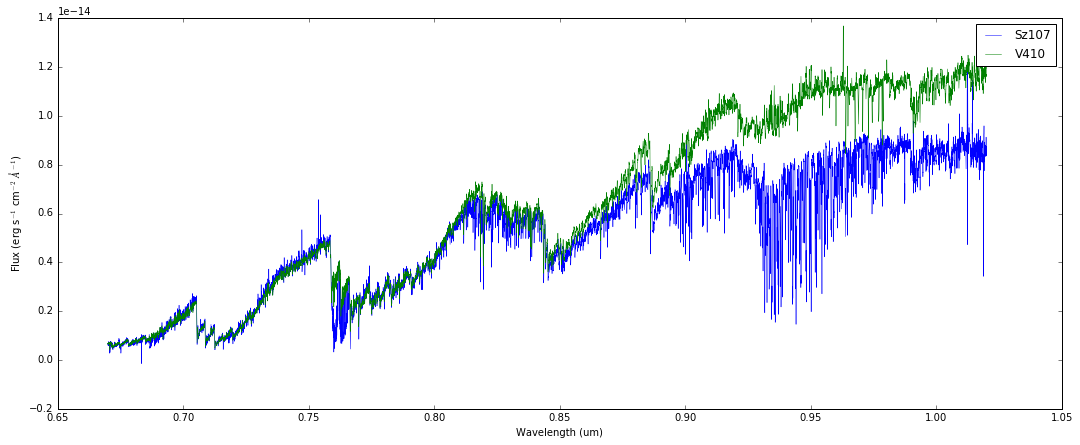

In [25]:
# plot template spectrum with random offset:
fig = plt.figure(figsize=(18,7))
# plt.plot(wavelength_object, newspec*1.63 + 0.75e-14, lw=0.5, label='Sz107')
plt.plot(wavelength_object, newspec*45, lw=0.5, label='Sz107')
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.plot(wavelength_object, newobj, lw=0.5, label='V410') 
plt.legend()
# plt.ylim(0,4)
# plt.xlim(2.46, 2.5)
plt.show()

In [ ]:
templates = ['Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_25.843.fits'] # nir

templates = ['Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_26.530.fits'] # opt - SZ107

templates = ['Extinction/Manara2013_Library/SO925/ADP.2014-05-13T15_37_26.653.fits'] # opt - SO925


# mini subset for testing
# models = models[:3]

# set up parameters for scaling object radius:
# sclrng = np.arange(0.1, 1.0, 0.2) # solar radii!

# dist = 119.37 # Gaia DR2

# set up extinction parameters:
ext = F99(Rv=3.1) 
avrng = np.arange(0, 4, 0.05) 

# set up range of accretion continuum flux to add to the templates
accretion_continuum_flux = np.linspace(0,1.5e-14,100) # need to measure veiling first!! See page 10 of HH14


len(templates)*len(avrng)*len(accretion_continuum_flux)

In [ ]:
def calc_best_template(wavelength_object, flux_object, uncertainty_object, templates, accretion_continuum_flux, avrng, sigclip = False):
    
    dof = len(wavelength_object) - 1
    minchi2 = np.zeros(len(templates))
    minradius = np.zeros(len(templates))
    
    # sigma-clip the flux values of the object
    flux_obj_clip = sigclip_spec(flux_object)
    
    # set up dictionary to store chi2 values
    chi2_dict = dict()

    for ii, template in enumerate(templates):
        print(template)
        
        # read in template
        templ_data = fits.getdata(template) 

        wavelength_t = templ_data[0][0]/1000 #convert to um
        flux_t = templ_data[0][1]
        uncertainty_t = templ_data[0][2]
        
        # rebin the template to match the same wavelength axis - should be nearly identical:
        templ_rebinflux = rebinspec(wavelength_t, flux_t, wavelength_object)

        if sigclip == True:
            # sigma-clip the flux values of the template
            flux_t_clip = sigclip_spec(templ_rebinflux)
        else:
            flux_t_clip = templ_rebinflux

        for acc_cont in accretion_continuum_flux:
            
            # add accretion luminosity to template:
            flux_t_clip_wacc = flux_t_clip + acc_cont
            
            for av in avrng:
                #print(av)
                
                # add extinction to the model 
                spectrum_ext = flux_t_clip_wacc*ext.extinguish(wavelength_object*u.um, Av=av)

                # calculate chi2 value for the extincted model
                tmp_chi2 = np.nansum(((flux_obj_clip - spectrum_ext)/uncertainty_object)**2) / dof 
                
                # add dictionary entry with tuple and chi2 value:
                chi2_dict[(template, acc_cont, av)] = tmp_chi2
                #print(tmp_chi2)


    minchi2 = min(chi2_dict.values())
    
    result = [k for k,v in chi2_dict.items() if v==minchi2]
    
        
    return result, minchi2

In [ ]:
t0 = time.time()

result, chi2 = calc_best_template(wavelength_object, flux_object, uncertainty_object, templates, accretion_continuum_flux, avrng)
    
t1 = time.time()

print("Time taken: ", np.round((t1-t0)/60., 2), " minutes")

In [ ]:
result, chi2

## Use best-fit values to examine template match:

In [ ]:
templ_data = fits.getdata(result[0][0]) 

wavelength_t = templ_data[0][0]/1000 #convert to um
flux_t = templ_data[0][1]
uncertainty_t = templ_data[0][2]
        
# rebin the template to match the same wavelength axis - should be nearly identical:
templ_rebinflux = rebinspec(wavelength_t, flux_t, wavelength_object)

# sigma-clip the flux values of the template
# flux_t_clip = sigclip_spec(templ_rebinflux)
# flux_t_clip_wacc = flux_t_clip + result[0][1]

# # and sigma-clip the object:
# newobj = sigclip_spec(flux_object)



# NO CLIP
flux_t_clip_wacc = templ_rebinflux

spectrum_ext = flux_t_clip_wacc*ext.extinguish(wavelength_object*u.um, Av=result[0][2])

In [ ]:
# plot reduced spectrum:
fig = plt.figure(figsize=(18,7))

plt.plot(wavelength_object, spectrum_ext, lw=1, label='Template')
plt.plot(wavelength_object, newobj, lw=1, label='V410')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# plt.xlim(0.805,0.83)
# plt.xlim(0.75, 0.79)
# plt.xlim(0.8, 0.9)
plt.ylim(0,2e-14)
plt.show()

In [ ]:
# Just out of curiosity - normalizing 

In [ ]:
fig = plt.figure(figsize=(18,7))

plt.plot(wavelength_object, spectrum_ext/np.median(spectrum_ext), label='Template')
plt.plot(wavelength_object, newobj/np.median(newobj), label='V410')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Normalized Flux')
# plt.xlim(0.805,0.83)
# plt.xlim(0.75, 0.79)
# plt.xlim(1.6, 1.7)
plt.show()

In [ ]:
## Save the output such that the these can be used for cross-correlating elsewhere:
np.savetxt('../RV/Empirical_Xshooter_forXCorr_Dec_NIR.txt', np.c_[wavelength_object, flux_object, uncertainty_object, spectrum_ext])

## A quick RV test...

In [ ]:
from PyAstronomy import pyasl

In [ ]:
fit_region = (wavelength_object > 0.95) & (wavelength_object < 0.99)
fit_region = (wavelength_object > 0.7) & (wavelength_object < 1.0)

In [ ]:
# normalize data:
dw = wavelength_object[fit_region]
df = (flux_object[fit_region])/np.median(flux_object[fit_region])

# template:
tw = wavelength_object[fit_region] # since we've resampled to the same wavelength axis
tf = (spectrum_ext[fit_region]/np.median(spectrum_ext[fit_region]))

In [ ]:
# Plot template and data
plt.title("Template (blue) and data (red)")
plt.plot(tw, tf, 'b-')
plt.plot(dw, df, 'r-')
# plt.xlim(2.28, 2.32)
plt.show()

In [ ]:
# Carry out the cross-correlation.
# The first and last 20 points of the data are skipped.
rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -50., 50., 10/100., skipedge=10, mode='doppler')

In [ ]:
# Find the index of maximum cross-correlation function
maxind = np.argmax(cc)

print("Cross-correlation function is maximized at dRV = ", rv[maxind], " km/s")
if rv[maxind] > 0.0:
  print("  A red-shift with respect to the template")
else:
  print("  A blue-shift with respect to the template")

plt.plot(rv, cc, 'bp-')
plt.plot(rv[maxind], cc[maxind], 'ro')
plt.show()
